In [16]:
!pip list

Package                   Version        Editable project location
------------------------- -------------- --------------------------------------------
aiofiles                  24.1.0
aiogram                   3.15.0
aiogram_dialog            2.2.0
aiohappyeyeballs          2.4.3
aiohttp                   3.10.10
aiolimiter                1.1.0
aiosignal                 1.3.1
annotated-types           0.7.0
anyio                     4.6.2.post1
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
async-timeout             4.0.3
attrs                     24.2.0
autoscraper               1.1.14
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.2.0
blis                      1.1.0
bs4                       0.0.2
cachetools                5.5.0
catalogue                 2.0.10
certifi                   2024.8.30
cffi                      

In [17]:
import re

import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt

### Загрузка данных из CSV файлов

In [18]:
chats_df = pd.read_csv('chat_links.csv')
cities_df = pd.read_csv('chat_messages_location.csv')
orgs_df = pd.read_csv('chat_messages_organisations.csv')

cities_df['cities'] = cities_df['cities'].apply(lambda x: eval(x) if isinstance(x, str) else [])
orgs_df['organisations'] = orgs_df['organisations'].apply(lambda x: eval(x) if isinstance(x, str) else [])

### Список городов и организаций для нормализации

In [19]:
cities = dict()
organisations = dict()

### Функция для нормализации названий с помощью fuzzy

In [20]:
def normalize_with_fuzzy(name, valid_names, threshold=60):
    # Используем process.extractOne для поиска наиболее похожего имени из списка
    if name[0] in valid_names:
        match = process.extractOne(name, valid_names[name[0]], scorer=fuzz.ratio)
        if match and match[1] >= threshold:  # Если найдено совпадение выше порога
            return match[0]
    else:
        valid_names[name[0]] = []
    valid_names[name[0]].append(name)
    return name  # Если совпадений нет, возвращаем исходное название

### Убираем все символы, не являющиеся буквами, цифрами, пробелами

In [21]:
def remove_special_characters_for_organisation(text):
    
    text = text.replace('\n', '')
    text = re.sub(r'[^\w\s-]', '', text)
    # emoji.replace_emoji(text, '')
    return text


def remove_special_characters_for_location(text):
    text = text.replace('\n', '')
    text = re.sub(r'[^A-Za-zА-Яа-яЁё\s-]', '', text)
    # emoji.replace_emoji(text, '')
    return text

def parse_arr_for_normalize(row):
    no_added_elems = []
    for i in range(len(row)):
        if " - " in row[i]:
            elems = row[i].split(" - ")
            row[i] = elems[0]
            no_added_elems.extend(elems[1:])
    row.extend(no_added_elems)

### Применяем нормализацию для городов и организаций

In [22]:
def normalize_cities(row):
    parse_arr_for_normalize(row)
    for i in range(len(row)):
        row[i] = remove_special_characters_for_location(row[i])
        row[i] = row[i].capitalize()
    ans = []
    for i in range(len(row)):
        if row[i] != '':
            ans += [normalize_with_fuzzy(row[i], cities)]
    return ans


def normalize_organisations(row):
    parse_arr_for_normalize(row)
    for i in range(len(row)):
        row[i] = remove_special_characters_for_organisation(row[i])
        row[i] = row[i].capitalize()
    ans = []
    for i in range(len(row)):
        if row[i] != '':
            ans += [normalize_with_fuzzy(row[i], organisations)]
    return ans

### Применяем нормализацию по строкам

In [32]:
cities_df['normalized_cities'] = cities_df['cities'].apply(normalize_cities)
orgs_df['normalized_organisations'] = orgs_df['organisations'].apply(normalize_organisations)

        id        chat_id                                       message_text  \
0        1 -1001997571298  Всем привет !\n#отвезу\nПредновогодний рейс🎄✈️...   
1        2 -1001997571298  Лечу 25 декабря ✈️\nКазань - Стамбул \nОбратно...   
2        3 -1001997571298  #отвезу✈️\n\nЧикаго - Москва\n\n29 декабря 🇺🇸\...   
3        4 -1001997571298  Добрый день!\n#отвезу\n22.12 Москва - Дубай \n...   
4        5 -1001997571298  # отвезу\n30 декабря лечу \nСтамбул Казань \nВ...   
...    ...            ...                                                ...   
2465  5004 -1001831068178  Приветствую! \n\n🇩🇪 *Из Германии* \n 20.12 в К...   
2466  5005 -1001831068178  Индивидуальный транспорт из Варшавы в Калининг...   
2467  5006 -1001831068178  Eu _ TRANSFER:\n🚨ИНДИВИДУАЛЬНЫЙ ТРАНСФЕР\n🇷🇺Ка...   
2468  5007 -1001831068178  ❇️❇️❇️❇️❇️Встречу  на границе  Калининградской...   
2469  5008 -1001831068178  Добрый вечер \nНужно одно место Калининград - ...   

                                       

### Теперь подсчитаеmм количество упоминаний городов и организаций

In [24]:
city_mentions = cities_df['normalized_cities'].explode().dropna()
org_mentions = orgs_df['normalized_organisations'].explode().dropna()

### Подсчитываем упоминания

In [25]:
city_counts = city_mentions.value_counts().head(20)
org_counts = org_mentions.value_counts().head(20)

# Строим графики

### График по городам

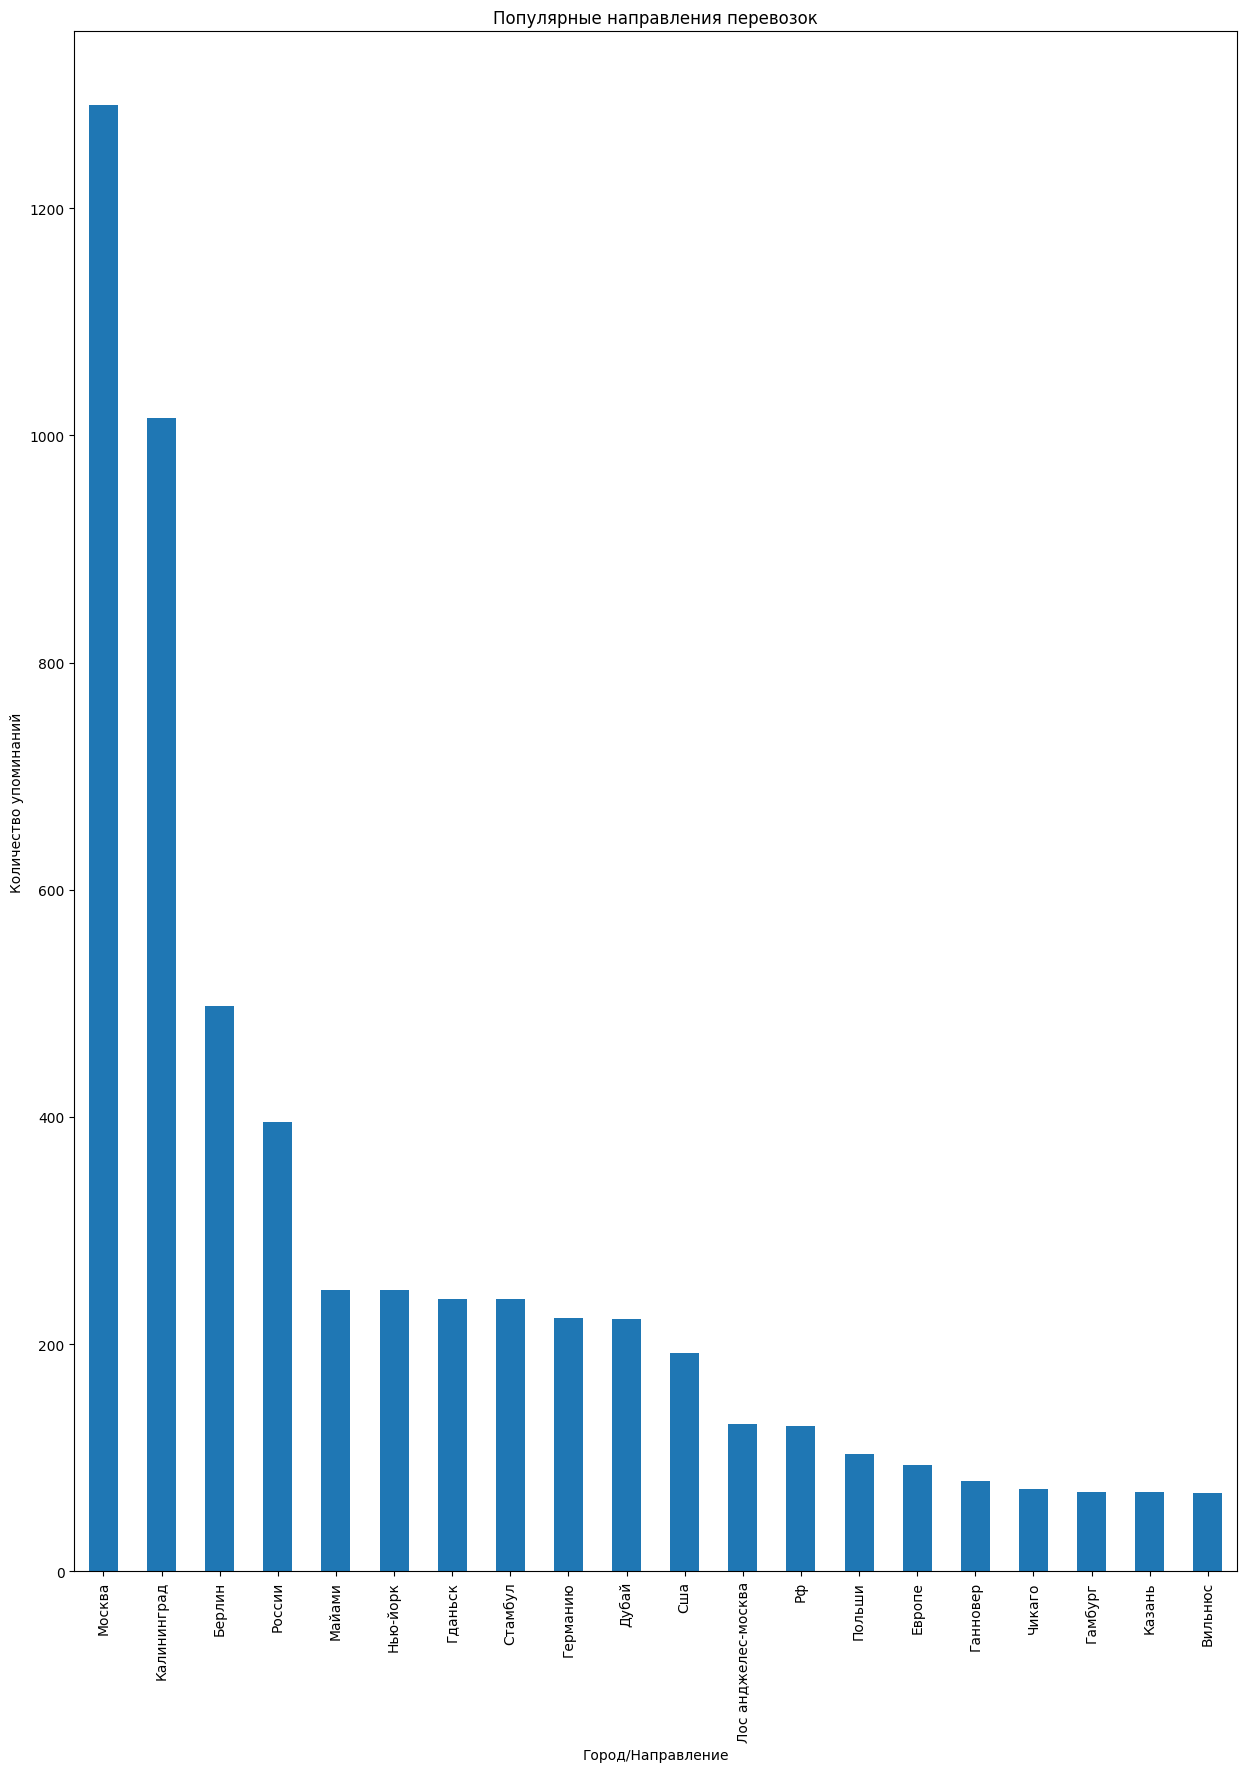

In [28]:
plt.figure(figsize=(15, 20))
city_counts.plot(kind='bar')
plt.title('Популярные направления перевозок')
plt.xlabel('Город/Направление')
plt.ylabel('Количество упоминаний')
plt.xticks(rotation=90)
plt.show()
plt.close()

# График по организациям

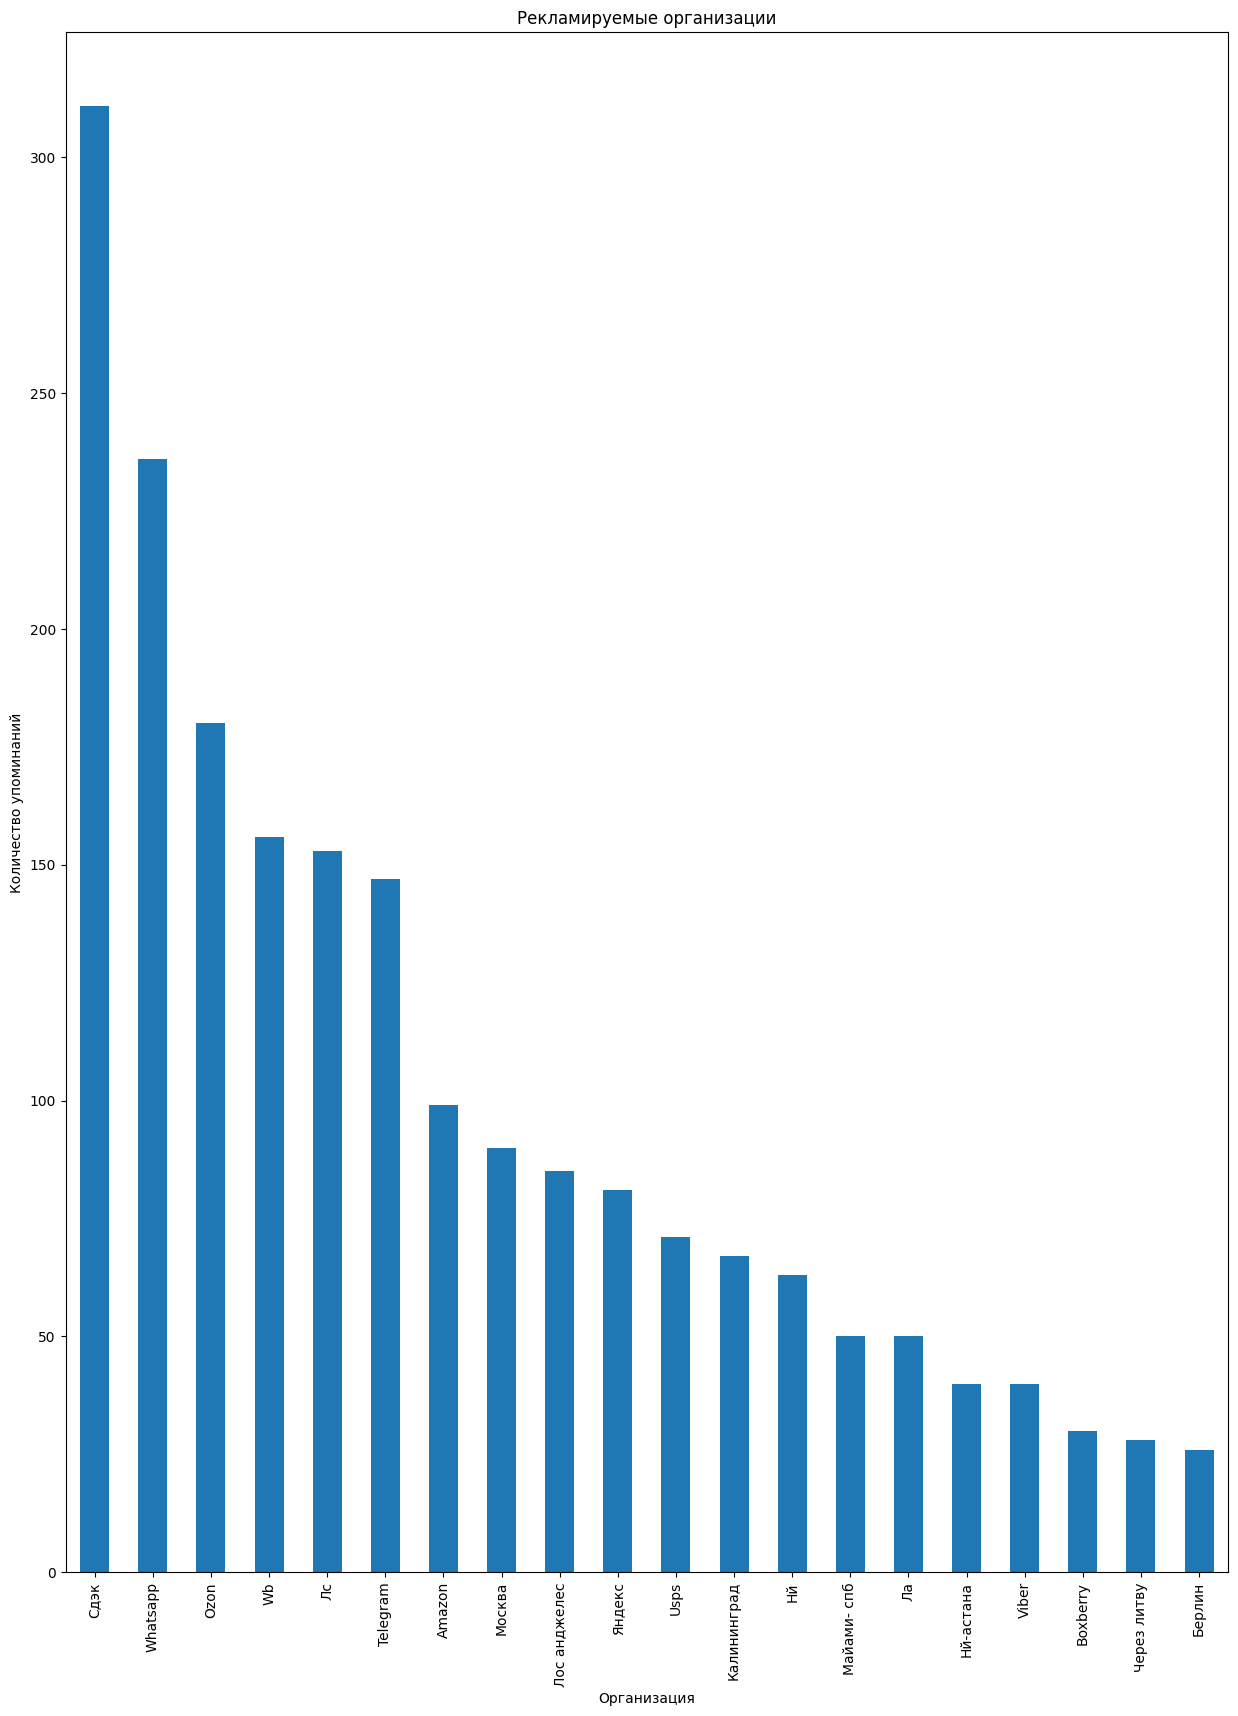

In [30]:
plt.figure(figsize=(15, 20))
org_counts.plot(kind='bar')
plt.title('Рекламируемые организации')
plt.xlabel('Организация')
plt.ylabel('Количество упоминаний')
plt.xticks(rotation=90)
plt.show()
plt.close()